In [12]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
env = gym.make('FrozenLake-v0')

[2017-09-11 13:20:18,431] Making new env: FrozenLake-v0


In [15]:
dtype = torch.FloatTensor # the CPU datatype

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [86]:
model = nn.Sequential(
        nn.Linear(16,4),
        )

model=model.type(dtype)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=0.1)

model.train()

Sequential (
  (0): Linear (16 -> 4)
)

In [100]:
#Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []

for i in range(num_episodes):
    
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    
    #The Q-Network
    while j < 99:
        j+=1
        network_in = torch.from_numpy(np.identity(16)[s:s+1])
        allQ = model(Variable(network_in.type(dtype)))
        
        _, a = torch.max(allQ, dim=1)
        
        if np.random.rand(1) < e:
            a[0] = env.action_space.sample()
        
        #Get new state and reward from environment
        s1,r,d,_ = env.step(a[0].data.numpy()[0])
        
        #Obtain the Q' values by feeding the new state through our network
        network_in2 = torch.from_numpy(np.identity(16)[s1:s1+1])
        Q1 = model(Variable(network_in2.type(dtype)))
   
        #Obtain maxQ' and set our target value for chosen action.
        maxQ1, _ = torch.max(Q1, dim=1)
        targetQ = allQ
        
        targetQ[0,a[0].data.numpy()[0]] = r + y*maxQ1
        
        #Train
        optimizer.zero_grad()
            
        network_in3 = torch.from_numpy(np.identity(16)[s:s+1])
        output = model(Variable(network_in3.type(dtype)))
        
        
        #print(list(model.parameters()))
        label = targetQ
        
        loss = torch.sum(torch.pow(output - label,2))    
        loss.backward()
        optimizer.step()
            
        rAll += r
        s = s1
        if d == True:
            #Reduce chance of random action as we train the model.
            e = 1./((i/50) + 10)
            break
                
    jList.append(j)
    rList.append(rAll)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

                

Percent of succesful episodes: 0.0245%


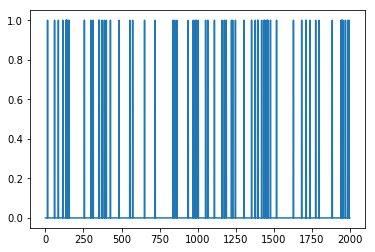

In [91]:
plt.plot(rList)

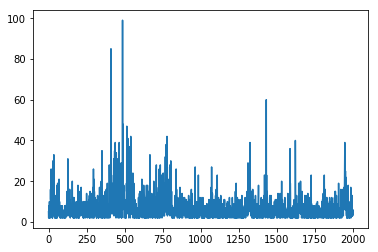

In [92]:
plt.plot(jList)